# Simulation

This part is a simple discrete simulation of a gas diffusion in a open area.
The gaz is continuously released from a source and diffuses in the area.

Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import scipy as sp

Set some constants

In [2]:
# Room dimensions
length = 10
width = 10

# Number of grid points
nx = 50
ny = 50

# Gas diffusion coefficient
D = 0.2

# Time step
dt = 0.01

# Grid spacing
dx = length / nx
dy = width / ny

# Initial concentration
C = np.zeros((nx, ny))

# Final time
tf = 100

# Source location (not centered)
source_x = nx // 2 + 5
source_y = ny // 2 - 5

# Source release rate
source_rate = 0.01

print(source_x, source_y)

30 20


The gaz is released at a constant rate from the source.

In [3]:
def diffuse_gaz():
    global C
    
    C[source_x, source_y] += source_rate

Simulate gas diffusion in a plane following Fick's 2nd law of diffusion :

$$
\frac{\delta C}{\delta t} = D \nabla^2 C
$$

where $C$ is the concentration of the gas, $D$ is the diffusion coefficient and $\nabla^2 C$ is the Laplacian operator : 

$$
\nabla^2 C = \frac{\delta^2 C}{\delta x^2} + \frac{\delta^2 C}{\delta y^2}
$$

Using the finite difference method, we can approximate the Laplacian operator as follows :

$$
\frac{\delta^2 C}{\delta x^2} \approx \frac{C_{i+1,j} - 2C_{i,j} + C_{i-1,j}}{\Delta x^2}
$$

$$
\frac{\delta^2 C}{\delta y^2} \approx \frac{C_{i,j+1} - 2C_{i,j} + C_{i,j-1}}{\Delta y^2}
$$

where $\Delta x$ and $\Delta y$ are the steps in the $x$ and $y$ directions.

In [4]:
def diffuse(D, dx, dy, dt):
    global C
    
    # Laplacian of C
    d2C_dx2 = (np.roll(C, 1, axis=0) - 2 * C + np.roll(C, -1, axis=0)) / dx**2
    d2C_dy2 = (np.roll(C, 1, axis=1) - 2 * C + np.roll(C, -1, axis=1)) / dy**2
    # We use np.roll since it is faster than for loops

    # Diffusion equation
    dC_dt = D * (d2C_dx2 + d2C_dy2)
        
    # Time integration
    C += dt * dC_dt
        
    # Boundary conditions (necessary in order to use np.roll + simulate an open area)
    C[0, :] = 0
    C[-1, :] = 0
    C[:, 0] = 0
    C[:, -1] = 0

Plot the animation of the gas diffusion in the area.

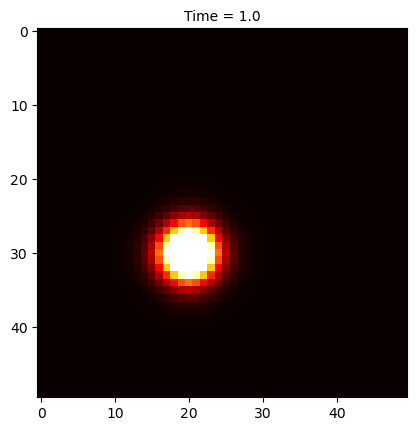

In [5]:
fig, ax = plt.subplots()

diffuse_gaz()
im = ax.imshow(C, cmap='hot', interpolation='nearest', animated=True)

text_label = ax.text(0.5, 1.01, "", ha='center', va='bottom', transform=ax.transAxes)

# Animation function
def update(frame):
    global C
    diffuse_gaz()
    diffuse(D, dx, dy, dt)

    global im
    im.set_array(C)
    text_label.set_text('Time = %.1f' % (frame * dt))
    return [im]

ani = animation.FuncAnimation(fig, update, frames=range(tf), blit=True)
HTML(ani.to_html5_video())

# Localisation of the source

We define sensors at random locations in the box and we measure the concentration of the gas at these locations.

In [6]:
sensors_position = np.array([[source_x + 5, source_y - 5],
                    [source_x - 15, source_y + 10],
                    [source_x + 17, source_y - 15]])

We get distance of each sensor to the source (qualitative information).

In [7]:
def get_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

sensors_distance = [get_distance(sensors_position[0], [source_x, source_y]),
                    get_distance(sensors_position[1], [source_x, source_y]),
                    get_distance(sensors_position[2], [source_x, source_y])]

sensors_distance

[7.0710678118654755, 18.027756377319946, 22.67156809750927]

We can use Delaunay triangulation to find the center of the source of the gas.

In [8]:
def locate(sensors_position, sensors_value):
    # Create the Delaunay triangulation
    triangle = sp.spatial.Delaunay(sensors_position)

    # Compute the barycenter of each triangle
    source_coordinates = np.average(sensors_position[triangle.simplices], axis=1, weights=sensors_value)

    return source_coordinates

We apply the Delaunay triangulation to the sensors values (currently, concentration of the gas at the sensors).

In [9]:
C = np.zeros((nx, ny))

sensors_values = np.zeros((1000, sensors_position.shape[0]))

for i in range(1000):
    diffuse_gaz()
    diffuse(D, dx, dy, dt)
    
    # Get the sensors values
    sensors_values[i] = C[sensors_position[:, 0], sensors_position[:, 1]]

    if sensors_values[i].sum() == 0:
        continue

    print(f"Source located at {locate(sensors_position, sensors_values[i])} (Error: {np.linalg.norm([source_x, source_y] - locate(sensors_position, sensors_values[i]))})")

Source located at [[47.  5.]] (Error: 22.67156809750927)
Source located at [[47.  5.]] (Error: 22.67156809750927)
Source located at [[47.  5.]] (Error: 22.67156809750927)
Source located at [[47.  5.]] (Error: 22.67156809750927)
Source located at [[47.  5.]] (Error: 22.67156809750927)
Source located at [[47.  5.]] (Error: 22.67156809750927)
Source located at [[47.  5.]] (Error: 22.67156809750927)
Source located at [[47.  5.]] (Error: 22.67156809750927)
Source located at [[47.  5.]] (Error: 22.67156809750927)
Source located at [[47.  5.]] (Error: 22.67156809750927)
Source located at [[47.  5.]] (Error: 22.67156809750927)
Source located at [[47.  5.]] (Error: 22.67156809750927)
Source located at [[47.  5.]] (Error: 22.67156809750927)
Source located at [[47.  5.]] (Error: 22.67156809750927)
Source located at [[47.  5.]] (Error: 22.67156809750927)
Source located at [[47.  5.]] (Error: 22.67156809750927)
Source located at [[47.  5.]] (Error: 22.671568097509272)
Source located at [[47.  5.]] 

The outcome deviates considerably from the source, yet it provides a satisfactory approximation. This disparity arises because Delaunay triangulation requires linear weights based on the distance to the sensors, which is not the case here given the gas concentration. By plotting the gas concentration at the sensors, it becomes evident that the concentration adheres to an inverse pattern, rather than a linear one.

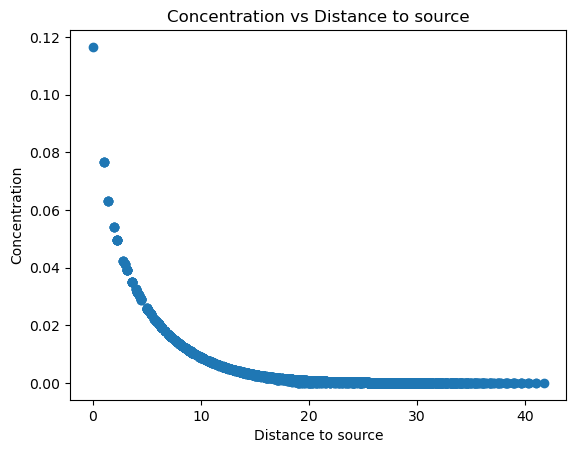

/tmp/ipykernel_138450/1620129382.py:17: RuntimeWarning: divide by zero encountered in log2
  plt.scatter(C_distance, np.log2(C_flatten))


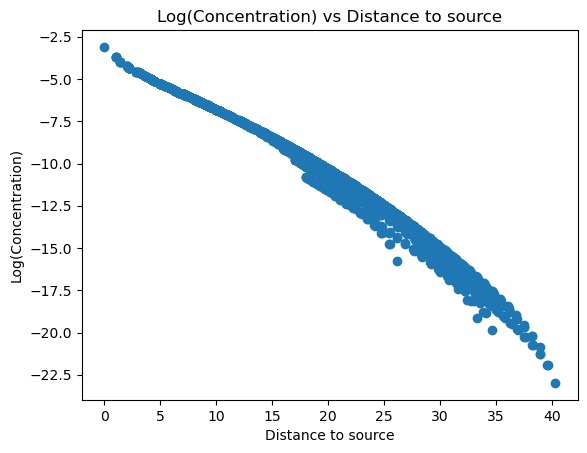

In [10]:
C_distance = np.zeros((nx, ny))

for i in range(nx):
    for j in range(ny):
        C_distance[i, j] = get_distance([i, j], [source_x, source_y])

# Flatten the matrix
C_distance = np.ravel(C_distance)
C_flatten = np.ravel(C)

plt.scatter(C_distance, C_flatten)
plt.xlabel("Distance to source")
plt.ylabel("Concentration")
plt.title("Concentration vs Distance to source")
plt.show()

plt.scatter(C_distance, np.log2(C_flatten))
plt.xlabel("Distance to source")
plt.ylabel("Log(Concentration)")
plt.title("Log(Concentration) vs Distance to source")
plt.show()

We can apply this to linearize sensors values to get a better approximation of the source.

In [11]:
for i in range(1000):    
    # Get the sensors values
    sensors_values[i] = C[sensors_position[:, 0], sensors_position[:, 1]]

    # Linearize the sensors values
    sensors_value = np.log2(sensors_values[i])

    # If all sensors are 0, we skip the iteration (Delaunay triangulation will fail)
    if sensors_value.sum() == 0:
        continue

    print(f"Source located at: {locate(sensors_position, sensors_value)} (Error: {np.linalg.norm(locate(sensors_position, sensors_value) - [source_x, source_y])})")

Source located at: [[28.72657902 19.49167431]] (Error: 1.3711294570498318)
Source located at: [[28.72657902 19.49167431]] (Error: 1.3711294570498318)
Source located at: [[28.72657902 19.49167431]] (Error: 1.3711294570498318)
Source located at: [[28.72657902 19.49167431]] (Error: 1.3711294570498318)
Source located at: [[28.72657902 19.49167431]] (Error: 1.3711294570498318)
Source located at: [[28.72657902 19.49167431]] (Error: 1.3711294570498318)
Source located at: [[28.72657902 19.49167431]] (Error: 1.3711294570498318)
Source located at: [[28.72657902 19.49167431]] (Error: 1.3711294570498318)
Source located at: [[28.72657902 19.49167431]] (Error: 1.3711294570498318)
Source located at: [[28.72657902 19.49167431]] (Error: 1.3711294570498318)
Source located at: [[28.72657902 19.49167431]] (Error: 1.3711294570498318)
Source located at: [[28.72657902 19.49167431]] (Error: 1.3711294570498318)
Source located at: [[28.72657902 19.49167431]] (Error: 1.3711294570498318)
Source located at: [[28.7